<a href="https://colab.research.google.com/github/cesarrivera52/Concentracion2/blob/main/Socio%20Formador/C%C3%B3digo/P11_v11/Regresiones_SF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
%pip install scipy

In [ ]:
%pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
#Cargamos librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as special
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
data=pd.read_csv('datos_limpios_sf_iqr.csv')
data.drop(columns='Unnamed: 0', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13803 entries, 0 to 13802
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Veloc   13803 non-null  float64
 1   Acele   13803 non-null  float64
 2   Des_x   13803 non-null  float64
 3   Des_y   13803 non-null  float64
 4   Des_z   13803 non-null  float64
 5   Presn   13803 non-null  float64
 6   VelPr   13803 non-null  float64
 7   AcePr   13803 non-null  float64
 8   F5EEX   13803 non-null  float64
 9   F6EES   13803 non-null  float64
 10  F8EIX   13803 non-null  float64
 11  F7EIS   13803 non-null  float64
 12  F9EEX   13803 non-null  float64
 13  F10ES   13803 non-null  float64
 14  F11EX   13803 non-null  float64
 15  F12ES   13803 non-null  float64
 16  F13EV   13803 non-null  float64
 17  F14EV   13803 non-null  float64
 18  F17MS   13803 non-null  float64
 19  F18MX   13803 non-null  float64
 20  F15MS   13803 non-null  float64
 21  F16MX   13803 non-null  float64
 22

# Procesamiento del df

In [ ]:
data_motivacion = data[data['04_M']==1]
data_motivacion.drop(columns=['01_C','02_A','03_D','04_M'], inplace=True)

In [ ]:
data_columnas = data_motivacion.columns

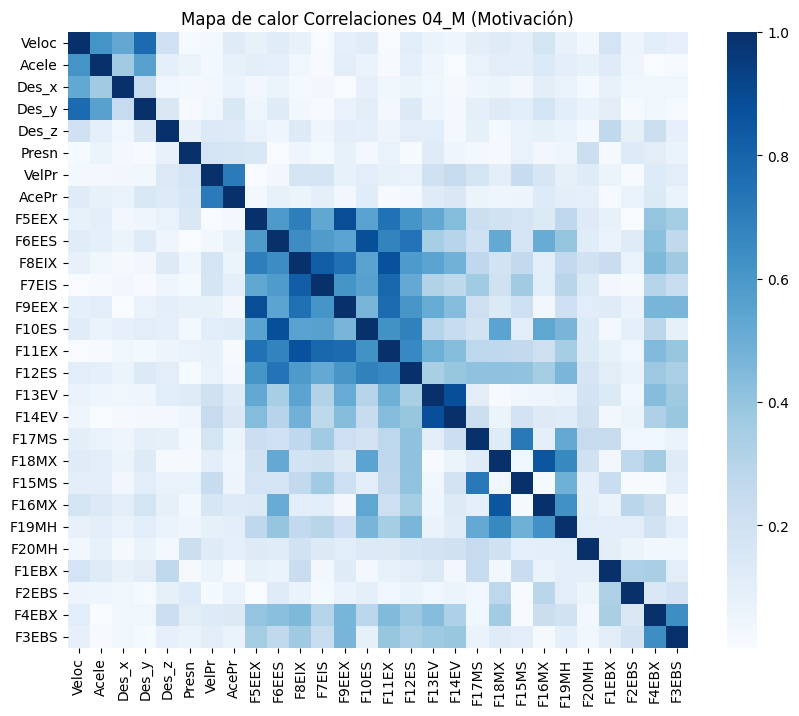

In [ ]:
# Calcular los coeficientes de correlación
corr_factors = data_motivacion.corr()
# Obtener el valor absoluto de las correlaciones
corr_factors1 = abs(corr_factors)

# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 8))  # Cambia los valores según sea necesario

# Crear el mapa de calor
Heat_Map = sns.heatmap(corr_factors1, cmap='Blues')  # 'annot=True' para mostrar los valores

# Título del mapa de calor
plt.title('Mapa de calor Correlaciones 04_M (Motivación)')
plt.show()

In [ ]:
# Inicializa el contador
contador = 0

# Crea una lista para almacenar los resultados
resultados = []

for variable in data_columnas:
    a = corr_factors1.sort_values(by=variable, ascending=False).head(7)
    a = a[1:].head(3)  # Selecciona las 3 variables independientes

    # Variable Independiente
    a1 = a.index[0]

    # Incrementa el contador
    contador += 1

    # Almacena los resultados en una lista de diccionarios
    resultados.append({
        'Variable dependiente (evaluando)': variable,
        'Variable independiente': a1
    })

# Convierte la lista de resultados en un DataFrame
df_resultados = pd.DataFrame(resultados)

# Muestra el DataFrame
df_resultados

df_resultados_heatmap_correlaciones= df_resultados.copy()

df_resultados_heatmap_correlaciones.to_csv('df_resultados_heatmap_correlaciones.csv')

# REGRESION NO LINEAL

MAin code

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings

# Ignorar advertencias para evitar mensajes no deseados
warnings.filterwarnings("ignore")

# Asumiendo que ya tienes cargado el DataFrame 'data_motivacion'

# Definir las funciones de los modelos
def modelo_cuadratico(x, a, b, c):
    return a * np.square(x) + b * x + c

def modelo_inverso(x, a):
    return 1 / (a * x + np.finfo(float).eps)  # Añadimos un pequeño valor para evitar división por cero

def modelo_senoidal(x, a, b):
    return a * np.sin(x) + b

def modelo_tangencial(x, a, b):
    return a * np.tan(x) + b

def modelo_valor_absoluto(x, a, b, c):
    return a * np.abs(x) + b * x + c

def modelo_cociente_polinomios(x, a, b, c):
    return (a * x**2 + b) / (c * x + np.finfo(float).eps)  # Evitar división por cero

def modelo_lineal_producto(x, a, b, c):
    return a * x + b * x + c * x

def modelo_cuadratico_inverso(x, a):
    return 1 / (a * x**2 + np.finfo(float).eps)  # Evitar división por cero

def modelo_polinomial_inverso(x, a, b, c):
    return a / (b * x**2 + np.finfo(float).eps) + c * x  # Evitar división por cero

# Lista de modelos a probar
modelos = [
    modelo_cuadratico,
    modelo_inverso,
    modelo_senoidal,
    modelo_tangencial,
    modelo_valor_absoluto,
    modelo_cociente_polinomios,
    modelo_lineal_producto,
    modelo_cuadratico_inverso,
    modelo_polinomial_inverso
]

def mejor_modelo(x, y, modelos):
    mejor_r2 = -np.inf
    mejor_modelo = None
    mejores_params = None

    for modelo in modelos:
        try:
            params, _ = curve_fit(modelo, x, y, maxfev=10000)
            y_pred = modelo(x, *params)
            r2 = r2_score(y, y_pred)

            if r2 > mejor_r2 and not np.isnan(r2) and not np.isinf(r2):
                mejor_r2 = r2
                mejor_modelo = modelo
                mejores_params = params
        except Exception as e:
            print(f"Error en el modelo {modelo.__name__}: {str(e)}")
            continue

    return mejor_modelo, mejores_params, mejor_r2

# Dataframe para almacenar los resultados
resultados = pd.DataFrame(columns=['Variable_Dependiente', 'Variable_Independiente', 'Mejor_Modelo', 'Coeficientes', 'R2'])

# Ciclo principal
for var_dep in data_motivacion.columns:
    for var_indep in data_motivacion.columns:
        if var_dep != var_indep:
            try:
                x = data_motivacion[var_indep].values
                y = data_motivacion[var_dep].values

                mejor_mod, params, r2 = mejor_modelo(x, y, modelos)

                if mejor_mod is not None:
                    nuevo_resultado = pd.DataFrame({
                        'Variable_Dependiente': [var_dep],
                        'Variable_Independiente': [var_indep],
                        'Mejor_Modelo': [mejor_mod.__name__],
                        'Coeficientes': [str(params)],
                        'R2': [r2]
                    })
                    resultados = pd.concat([resultados, nuevo_resultado], ignore_index=True)
            except Exception as e:
                print(f"Error en el par ({var_dep}, {var_indep}): {str(e)}")

# Ordenar resultados por R2 de mayor a menor
resultados = resultados.sort_values('R2', ascending=False)

# Mostrar los mejores resultados
print(resultados.head(10))

# Guardar resultados en un archivo CSV
resultados.to_csv('resultados_regresion_no_lineal1.csv', index=False)

    Variable_Dependiente Variable_Independiente               Mejor_Modelo  \
332                F9EEX                  F5EEX          modelo_cuadratico   
227                F5EEX                  F9EEX            modelo_senoidal   
448                F13EV                  F14EV          modelo_cuadratico   
475                F14EV                  F13EV          modelo_cuadratico   
255                F6EES                  F10ES  modelo_polinomial_inverso   
360                F10ES                  F6EES          modelo_cuadratico   
388                F11EX                  F8EIX            modelo_senoidal   
283                F8EIX                  F11EX            modelo_senoidal   
533                F18MX                  F16MX          modelo_cuadratico   
586                F16MX                  F18MX            modelo_senoidal   

                                 Coeficientes        R2  
332     [-0.33851507  1.25679273 -0.03112387]  0.788321  
227                   [0.

In [ ]:
resultados[resultados['Variable_Dependiente']=='F5EEX']

,Variable_Dependiente,Variable_Independiente,Mejor_Modelo,Coeficientes,R2
227,F5EEX,F9EEX,modelo_senoidal,[0.92015057 0.0386063 ],0.788142
229,F5EEX,F11EX,modelo_cuadratico,[-0.3959556 1.16162478 -0.00962766],0.559216
225,F5EEX,F8EIX,modelo_cuadratico,[-0.52180092 1.16873519 0.02301077],0.496010
230,F5EEX,F12ES,modelo_cuadratico,[0.39530397 0.21418363 0.24258975],0.377016
224,F5EEX,F6EES,modelo_cuadratico,[0.2088591 0.40080882 0.21008098],0.346661
228,F5EEX,F10ES,modelo_cuadratico,[ 0.77342188 -0.19109897 0.33891492],0.314515
226,F5EEX,F7EIS,modelo_cuadratico,[-0.82438659 1.28658588 0.05119672],0.292793
231,F5EEX,F13EV,modelo_cuadratico,[-0.24996486 0.6525564 0.19165551],0.278180
232,F5EEX,F14EV,modelo_cuadratico,[-0.17833617 0.48598539 0.26139536],0.194682
241,F5EEX,F4EBX,modelo_cuadratico,[-0.29450904 0.56660416 0.25970756],0.162716


### Top 5 modelos

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings
from heapq import nlargest

# Ignorar advertencias para evitar mensajes no deseados
warnings.filterwarnings("ignore")

# Asumiendo que ya tienes cargado el DataFrame 'data_motivacion'

# Definir las funciones de los modelos
def modelo_cuadratico(x, a, b, c):
    return a * np.square(x) + b * x + c

def modelo_inverso(x, a):
    return 1 / (a * x + np.finfo(float).eps)  # Añadimos un pequeño valor para evitar división por cero

def modelo_senoidal(x, a, b):
    return a * np.sin(x) + b

def modelo_tangencial(x, a, b):
    return a * np.tan(x) + b

def modelo_valor_absoluto(x, a, b, c):
    return a * np.abs(x) + b * x + c

def modelo_cociente_polinomios(x, a, b, c):
    return (a * x**2 + b) / (c * x + np.finfo(float).eps)  # Evitar división por cero

def modelo_lineal_producto(x, a, b, c):
    return a * x + b * x + c * x

def modelo_cuadratico_inverso(x, a):
    return 1 / (a * x**2 + np.finfo(float).eps)  # Evitar división por cero

def modelo_polinomial_inverso(x, a, b, c):
    return a / (b * x**2 + np.finfo(float).eps) + c * x  # Evitar división por cero

# Lista de modelos a probar
modelos = [
    modelo_cuadratico,
    modelo_inverso,
    modelo_senoidal,
    modelo_tangencial,
    modelo_valor_absoluto,
    modelo_cociente_polinomios,
    modelo_lineal_producto,
    modelo_cuadratico_inverso,
    modelo_polinomial_inverso
]

def mejor_modelo(x, y, modelos):
    mejor_r2 = -np.inf
    mejor_mod = None
    mejores_params = None

    for modelo in modelos:
        try:
            params, _ = curve_fit(modelo, x, y)
            y_pred = modelo(x, *params)
            r2 = r2_score(y, y_pred)
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_mod = modelo
                mejores_params = params
        except:
            continue

    return mejor_mod, mejores_params, mejor_r2

# Lista para almacenar los resultados
resultados = []

# Ciclo principal
for _, row in df_resultados.iterrows():
    var_dep = row['Variable dependiente (evaluando)']
    var_indep = row['Variable independiente']

    try:
        x = data_motivacion[var_indep].values
        y = data_motivacion[var_dep].values

        mejor_mod, params, r2 = mejor_modelo(x, y, modelos)

        if mejor_mod is not None:
            resultados.append({
                'var_dep': var_dep,
                'var_indep': var_indep,
                'modelo': mejor_mod,
                'params': params,
                'r2': r2,
                'x': x,
                'y': y
            })

            print(f"Modelo ajustado para {var_dep} vs {var_indep}")
    except Exception as e:
        print(f"Error en el par ({var_dep}, {var_indep}): {str(e)}")

# Seleccionar los 5 mejores modelos basados en R²
mejores_5 = nlargest(5, resultados, key=lambda k: k['r2'])

# Crear y guardar los DataFrames para los 5 mejores modelos
for i, resultado in enumerate(mejores_5, 1):
    df_resultado = pd.DataFrame({
        'x': resultado['x'],
        'y_real': resultado['y'],
        'y_prediccion': resultado['modelo'](resultado['x'], *resultado['params'])
    })

    df_resultado['Variable_Dependiente'] = resultado['var_dep']
    df_resultado['Variable_Independiente'] = resultado['var_indep']
    df_resultado['Modelo'] = resultado['modelo'].__name__
    df_resultado['R2'] = resultado['r2']

    nombre_archivo = f'top_{i}_regresion_NO_Lineal_{resultado["var_dep"]}_vs_{resultado["var_indep"]}.csv'.replace(' ', '_')
    df_resultado.to_csv(nombre_archivo, index=False)
    print(f"Archivo guardado: {nombre_archivo}")

print(f"Se han creado 5 archivos CSV con los mejores modelos.")

Modelo ajustado para Veloc vs Des_y
Modelo ajustado para Acele vs Veloc
Modelo ajustado para Des_x vs Veloc
Modelo ajustado para Des_y vs Veloc
Modelo ajustado para Des_z vs F1EBX
Modelo ajustado para Presn vs F20MH
Modelo ajustado para VelPr vs AcePr
Modelo ajustado para AcePr vs VelPr
Modelo ajustado para F5EEX vs F9EEX
Modelo ajustado para F6EES vs F10ES
Modelo ajustado para F8EIX vs F11EX
Modelo ajustado para F7EIS vs F8EIX
Modelo ajustado para F9EEX vs F5EEX
Modelo ajustado para F10ES vs F6EES
Modelo ajustado para F11EX vs F8EIX
Modelo ajustado para F12ES vs F6EES
Modelo ajustado para F13EV vs F14EV
Modelo ajustado para F14EV vs F13EV
Modelo ajustado para F17MS vs F15MS
Modelo ajustado para F18MX vs F16MX
Modelo ajustado para F15MS vs F17MS
Modelo ajustado para F16MX vs F18MX
Modelo ajustado para F19MH vs F18MX
Modelo ajustado para F20MH vs F17MS
Modelo ajustado para F1EBX vs F4EBX
Modelo ajustado para F2EBS vs F1EBX
Modelo ajustado para F4EBX vs F3EBS
Modelo ajustado para F3EBS v

# Regresión Lineal

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Asumiendo que ya tienes df_resultados y data_motivacion

# Lista para almacenar los resultados de la regresión
resultados_regresion = []

for index, row in df_resultados.iterrows():
    var_dep = row['Variable dependiente (evaluando)']
    var_indep = row['Variable independiente']

    try:
        X = data_motivacion[[var_indep]]
        y = data_motivacion[var_dep]

        # Crear y ajustar el modelo
        model = LinearRegression()
        model.fit(X, y)

        # Hacer predicciones
        y_pred = model.predict(X)

        # Calcular R^2
        r2 = r2_score(y, y_pred)

        # Guardar resultados
        resultados_regresion.append({
            'Variable dependiente': var_dep,
            'Variable independiente': var_indep,
            'R^2': r2,
            'Coeficiente': model.coef_[0],
            'Intercepto': model.intercept_
        })

        print(f"Modelo ajustado para {var_dep} vs {var_indep}")
    except Exception as e:
        print(f"Error en el par ({var_dep}, {var_indep}): {str(e)}")

# Crear DataFrame con los resultados de la regresión
df_resultados_regresion = pd.DataFrame(resultados_regresion)

# Ordenar por R^2 descendente
df_resultados_regresion = df_resultados_regresion.sort_values('R^2', ascending=False)

# Guardar resultados
df_resultados_regresion.to_csv('resultados_regresiones_LINEAL.csv', index=False)
print("Tabla de resultados detallados guardada en 'resultados_regresiones_detallados.csv'")

# Mostrar los mejores modelos
print("\nLos mejores modelos:")
df_resultados_regresion


Modelo ajustado para Veloc vs Des_y
Modelo ajustado para Acele vs Veloc
Modelo ajustado para Des_x vs Veloc
Modelo ajustado para Des_y vs Veloc
Modelo ajustado para Des_z vs F1EBX
Modelo ajustado para Presn vs F20MH
Modelo ajustado para VelPr vs AcePr
Modelo ajustado para AcePr vs VelPr
Modelo ajustado para F5EEX vs F9EEX
Modelo ajustado para F6EES vs F10ES
Modelo ajustado para F8EIX vs F11EX
Modelo ajustado para F7EIS vs F8EIX
Modelo ajustado para F9EEX vs F5EEX
Modelo ajustado para F10ES vs F6EES
Modelo ajustado para F11EX vs F8EIX
Modelo ajustado para F12ES vs F6EES
Modelo ajustado para F13EV vs F14EV
Modelo ajustado para F14EV vs F13EV
Modelo ajustado para F17MS vs F15MS
Modelo ajustado para F18MX vs F16MX
Modelo ajustado para F15MS vs F17MS
Modelo ajustado para F16MX vs F18MX
Modelo ajustado para F19MH vs F18MX
Modelo ajustado para F20MH vs F17MS
Modelo ajustado para F1EBX vs F4EBX
Modelo ajustado para F2EBS vs F1EBX
Modelo ajustado para F4EBX vs F3EBS
Modelo ajustado para F3EBS v

,Variable dependiente,Variable independiente,R^2,Coeficiente,Intercepto
12,F9EEX,F5EEX,0.786570,0.956124,0.032177
8,F5EEX,F9EEX,0.786570,0.822665,0.066270
17,F14EV,F13EV,0.782132,0.947023,-0.003493
16,F13EV,F14EV,0.782132,0.825885,0.102888
9,F6EES,F10ES,0.778755,0.895122,0.017187
13,F10ES,F6EES,0.778755,0.869998,0.091900
10,F8EIX,F11EX,0.759652,0.940283,0.016104
14,F11EX,F8EIX,0.759652,0.807898,0.096683
21,F16MX,F18MX,0.726082,0.792504,0.182016
19,F18MX,F16MX,0.726082,0.916187,-0.052890


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from heapq import nlargest
import pandas as pd
import numpy as np

# Asumiendo que ya tienes df_resultados_regresion con los resultados de la regresión

# Seleccionar los 5 mejores modelos basados en R²
mejores_5 = df_resultados_regresion.nlargest(5, 'R^2')

# Crear y guardar los DataFrames para los 5 mejores modelos
for i, (index, resultado) in enumerate(mejores_5.iterrows(), 1):
    var_dep = resultado['Variable dependiente']
    var_indep = resultado['Variable independiente']

    # Obtener los datos originales
    x = data_motivacion[var_indep]
    y_real = data_motivacion[var_dep]

    # Calcular y_prediccion
    y_prediccion = resultado['Coeficiente'] * x + resultado['Intercepto']

    df_resultado = pd.DataFrame({
        'x': x,
        'y_real': y_real,
        'y_prediccion': y_prediccion
    })

    df_resultado['Variable_Dependiente'] = var_dep
    df_resultado['Variable_Independiente'] = var_indep
    df_resultado['Modelo'] = 'Regresión Lineal'
    df_resultado['R2'] = resultado['R^2']

    nombre_archivo = f'top_{i}_regresion_Lineal_{var_dep}_vs_{var_indep}.csv'.replace(' ', '_')
    df_resultado.to_csv(nombre_archivo, index=False)
    print(f"Archivo guardado: {nombre_archivo}")

print(f"Se han creado 5 archivos CSV con los mejores modelos.")

Archivo guardado: top_1_regresion_Lineal_F9EEX_vs_F5EEX.csv
Archivo guardado: top_2_regresion_Lineal_F5EEX_vs_F9EEX.csv
Archivo guardado: top_3_regresion_Lineal_F14EV_vs_F13EV.csv
Archivo guardado: top_4_regresion_Lineal_F13EV_vs_F14EV.csv
Archivo guardado: top_5_regresion_Lineal_F6EES_vs_F10ES.csv
Se han creado 5 archivos CSV con los mejores modelos.


### Mejores top 5 modelos para graficar

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Asumiendo que ya tienes df_resultados y data_motivacion

# Lista para almacenar los resultados de la regresión
resultados_regresion = []
mejores_modelos = []

for index, row in df_resultados.iterrows():
    var_dep = row['Variable dependiente (evaluando)']
    var_indep = row['Variable independiente']

    try:
        # Verificar si las variables son numéricas
        if data_motivacion[var_dep].dtype == 'object' or data_motivacion[var_indep].dtype == 'object':
            print(f"Saltando el par ({var_dep}, {var_indep}) porque una o ambas variables no son numéricas.")
            continue

        X = data_motivacion[[var_indep]]
        y = data_motivacion[var_dep]

        # Crear y ajustar el modelo
        model = LinearRegression()
        model.fit(X, y)

        # Hacer predicciones
        y_pred = model.predict(X)

        # Calcular R^2
        r2 = r2_score(y, y_pred)

        # Guardar resultados
        resultados_regresion.append({
            'Variable dependiente': var_dep,
            'Variable independiente': var_indep,
            'R^2': r2,
            'Coeficiente': model.coef_[0],
            'Intercepto': model.intercept_
        })

        # Guardar datos para los mejores modelos
        mejores_modelos.append({
            'var_dep': var_dep,
            'var_indep': var_indep,
            'X': X,
            'y': y,
            'y_pred': y_pred,
            'r2': r2
        })

        print(f"Modelo ajustado para {var_dep} vs {var_indep}")
    except Exception as e:
        print(f"Error en el par ({var_dep}, {var_indep}): {str(e)}")

# Crear DataFrame con los resultados de la regresión
df_resultados_regresion = pd.DataFrame(resultados_regresion)

# Ordenar por R^2 descendente
df_resultados_regresion = df_resultados_regresion.sort_values('R^2', ascending=False)

# Guardar resultados generales
print("Tabla de resultados detallados guardada en 'resultados_regresiones_detallados.csv'")

# Mostrar los mejores modelos
print("\nLos mejores modelos:")
print(df_resultados_regresion.head())

df_resultados_regresion.to_csv('mejores_modelos_lineal.csv')


# Crear mapa de calor de correlaciones solo para variables numéricas


Modelo ajustado para Veloc vs Des_y
Modelo ajustado para Acele vs Veloc
Modelo ajustado para Des_x vs Veloc
Modelo ajustado para Des_y vs Veloc
Modelo ajustado para Des_z vs F1EBX
Modelo ajustado para Presn vs F20MH
Modelo ajustado para VelPr vs AcePr
Modelo ajustado para AcePr vs VelPr
Modelo ajustado para F5EEX vs F9EEX
Modelo ajustado para F6EES vs F10ES
Modelo ajustado para F8EIX vs F11EX
Modelo ajustado para F7EIS vs F8EIX
Modelo ajustado para F9EEX vs F5EEX
Modelo ajustado para F10ES vs F6EES
Modelo ajustado para F11EX vs F8EIX
Modelo ajustado para F12ES vs F6EES
Modelo ajustado para F13EV vs F14EV
Modelo ajustado para F14EV vs F13EV
Modelo ajustado para F17MS vs F15MS
Modelo ajustado para F18MX vs F16MX
Modelo ajustado para F15MS vs F17MS
Modelo ajustado para F16MX vs F18MX
Modelo ajustado para F19MH vs F18MX
Modelo ajustado para F20MH vs F17MS
Modelo ajustado para F1EBX vs F4EBX
Modelo ajustado para F2EBS vs F1EBX
Modelo ajustado para F4EBX vs F3EBS
Modelo ajustado para F3EBS v

# Regresion Logística

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Asumiendo que tienes tu DataFrame 'data_motivacion'

# Función para realizar regresión logística
def realizar_regresion_logistica(X, y, var_indep, var_dep):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Escalar las características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Crear y entrenar el modelo
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test_scaled)

    # Calcular la precisión
    accuracy = accuracy_score(y_test, y_pred)

    # Crear una matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Generar un informe de clasificación
    report = classification_report(y_test, y_pred)

    return model, accuracy, cm, report, X_test, y_test, y_pred

# Lista para almacenar los resultados
resultados_logistica = []

# Iterar sobre las combinaciones de variables
for index, row in df_resultados.iterrows():
    var_dep = row['Variable dependiente (evaluando)']
    var_indep = row['Variable independiente']

    # Verificar si las variables son numéricas
    if data_motivacion[var_dep].dtype == 'object' or data_motivacion[var_indep].dtype == 'object':
        print(f"Saltando el par ({var_dep}, {var_indep}) porque una o ambas variables no son numéricas.")
        continue

    # Preparar los datos
    X = data_motivacion[[var_indep]]
    y = data_motivacion[var_dep]

    # Convertir y a binario si no lo es
    if len(y.unique()) > 2:
        y = (y > y.median()).astype(int)

    try:
        # Realizar la regresión logística
        model, accuracy, cm, report, X_test, y_test, y_pred = realizar_regresion_logistica(X, y, var_indep, var_dep)

        # Guardar resultados
        resultados_logistica.append({
            'Variable dependiente': var_dep,
            'Variable independiente': var_indep,
            'Accuracy': accuracy,
            'Confusion Matrix': cm,
            'Classification Report': report,
            'X_test': X_test,
            'y_test': y_test,
                        'y_pred': y_pred
        })

        print(f"Modelo logístico ajustado para {var_dep} vs {var_indep}")
    except Exception as e:
        print(f"Error en el par ({var_dep}, {var_indep}): {str(e)}")

# Crear DataFrame con los resultados de la regresión logística
df_resultados_logistica = pd.DataFrame(resultados_logistica)

# Ordenar por precisión descendente
df_resultados_logistica = df_resultados_logistica.sort_values('Accuracy', ascending=False)

# Guardar los 5 mejores modelos en DataFrames separados
for i in range(min(5, len(df_resultados_logistica))):
    resultado = df_resultados_logistica.iloc[i]
    df_modelo = pd.DataFrame({
        'x_original': resultado['X_test'].iloc[:, 0],
        'y_original': resultado['y_test'],
        'y_predicho': resultado['y_pred']
    })
    nombre_archivo = f'top_{i+1}_regresion_logistica_{resultado["Variable dependiente"]}_vs_{resultado["Variable independiente"]}.csv'
    df_modelo.to_csv(nombre_archivo, index=False)
    print(f"Datos del modelo logístico {i+1} guardados en '{nombre_archivo}'")

# Guardar resultados generales
df_resultados_logistica.to_csv('resultados_regresiones_logisticas.csv', index=False)
print("Tabla de resultados detallados de regresión logística guardada en 'resultados_regresiones_logisticas.csv'")

# Mostrar los mejores modelos
print("\nLos mejores modelos de regresión logística:")
print(df_resultados_logistica[['Variable dependiente', 'Variable independiente', 'Accuracy']].head())

# Visualizar la matriz de confusión del mejor modelo
mejor_modelo = df_resultados_logistica.iloc[0]
plt.figure(figsize=(8, 6))
sns.heatmap(mejor_modelo['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión: {mejor_modelo["Variable dependiente"]} vs {mejor_modelo["Variable independiente"]}')
plt.savefig('mejor_modelo_logistico_confusion_matrix.png')
plt.close()

print(f"\nInforme de clasificación del mejor modelo ({mejor_modelo['Variable dependiente']} vs {mejor_modelo['Variable independiente']}):")
print(mejor_modelo['Classification Report'])

Modelo logístico ajustado para Veloc vs Des_y
Modelo logístico ajustado para Acele vs Veloc
Modelo logístico ajustado para Des_x vs Veloc
Modelo logístico ajustado para Des_y vs Veloc
Modelo logístico ajustado para Des_z vs F1EBX
Modelo logístico ajustado para Presn vs F20MH
Modelo logístico ajustado para VelPr vs AcePr
Modelo logístico ajustado para AcePr vs VelPr
Modelo logístico ajustado para F5EEX vs F9EEX
Modelo logístico ajustado para F6EES vs F10ES
Modelo logístico ajustado para F8EIX vs F11EX
Modelo logístico ajustado para F7EIS vs F8EIX
Modelo logístico ajustado para F9EEX vs F5EEX
Modelo logístico ajustado para F10ES vs F6EES
Modelo logístico ajustado para F11EX vs F8EIX
Modelo logístico ajustado para F12ES vs F6EES
Modelo logístico ajustado para F13EV vs F14EV
Modelo logístico ajustado para F14EV vs F13EV
Modelo logístico ajustado para F17MS vs F15MS
Modelo logístico ajustado para F18MX vs F16MX
Modelo logístico ajustado para F15MS vs F17MS
Modelo logístico ajustado para F16

# Regresion Multiple

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt  # Asegúrate de importar matplotlib para la visualización

# Inicializa el contador
contador = 0

# Crea una lista para almacenar los resultados
resultados = []

for variable in data_columnas:
    a = corr_factors1.sort_values(by=variable, ascending=False).head(7)
    a = a[1:].head(6)  # Selecciona las 6 variables independientes más correlacionadas

    # Variables Independientes
    vars_indep = a.index.tolist()

    # Incrementa el contador
    contador += 1

    # Almacena los resultados en una lista de diccionarios
    resultados.append({
        'Variable dependiente (evaluando)': variable,
        'Variables independientes': vars_indep
    })

# Convierte la lista de resultados en un DataFrame
df_resultados = pd.DataFrame(resultados)

# Lista para almacenar los resultados de la regresión
resultados_regresion_multiple = []

def realizar_regresion_multiple(X, y, vars_indep, var_dep):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Escalar las características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Crear y entrenar el modelo
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test_scaled)

    # Calcular R²
    r2 = r2_score(y_test, y_pred)

    return model, r2, y_test, y_pred

for index, row in df_resultados.iterrows():
    var_dep = row['Variable dependiente (evaluando)']
    vars_indep = row['Variables independientes']

    try:
        X = data_motivacion[vars_indep]
        y = data_motivacion[var_dep]

        # Realizar la regresión múltiple
        model, r2, y_test, y_pred = realizar_regresion_multiple(X, y, vars_indep, var_dep)

        # Guardar resultados
        resultados_regresion_multiple.append({
            'Variable dependiente': var_dep,
            'Variables independientes': vars_indep,
            'R^2': r2,
            'Coeficientes': dict(zip(vars_indep, model.coef_)),
            'Intercepto': model.intercept_
        })

        print(f"Modelo múltiple ajustado para {var_dep}")
    except Exception as e:
        print(f"Error en el modelo con {var_dep} como dependiente: {str(e)}")

# Crear DataFrame con los resultados de la regresión
df_resultados_regresion_multiple = pd.DataFrame(resultados_regresion_multiple)

# Ordenar por R^2 descendente
df_resultados_regresion_multiple = df_resultados_regresion_multiple.sort_values('R^2', ascending=False)

# Guardar resultados
df_resultados_regresion_multiple.to_csv('resultados_regresiones_lineal_multiple.csv', index=False)
print("Tabla de resultados detallados guardada en 'resultados_regresiones_multiple.csv'")

# Mostrar los mejores modelos
print("\nLos mejores modelos:")
print(df_resultados_regresion_multiple)

# Visualizar el mejor modelo
mejor_modelo = df_resultados_regresion_multiple.iloc[0]
plt.figure(figsize=(10, 6))

# Obtenemos las variables independientes y los coeficientes
variables_independientes = mejor_modelo['Variables independientes']
coeficientes = mejor_modelo['Coeficientes']

# Aseguramos que variables_independientes y coeficientes sean listas
if not isinstance(variables_independientes, list):
    variables_independientes = [variables_independientes]

try:
    # Aseguramos que coeficientes sea un diccionario
    if isinstance(coeficientes, dict):
        # Calculamos los valores predichos
        valores_predichos = sum(data_motivacion[var] * coeficientes[var] for var in variables_independientes)
        valores_predichos += mejor_modelo['Intercepto']
    else:
        raise TypeError("coeficientes debe ser un diccionario.")

except KeyError as e:
    print(f"Error: No se encontró la variable '{e}' en los coeficientes.")
except TypeError as e:
    print(f"Error de tipo: {str(e)}")
except Exception as e:
    print(f"Se produjo un error inesperado: {str(e)}")

# Si no hubo errores
else:
    print(f"\nMejor modelo:")
    print(f"Variable dependiente: {mejor_modelo['Variable dependiente']}")
    print(f"Variables independientes: {variables_independientes}")
    print(f"R^2: {mejor_modelo['R^2']}")
    print("Coeficientes:")
    for var, coef in zip(variables_independientes, coeficientes):
        print(f"  {var}: {coef}")
    print(f"Intercepto: {mejor_modelo['Intercepto']}")

Modelo múltiple ajustado para Veloc
Modelo múltiple ajustado para Acele
Modelo múltiple ajustado para Des_x
Modelo múltiple ajustado para Des_y
Modelo múltiple ajustado para Des_z
Modelo múltiple ajustado para Presn
Modelo múltiple ajustado para VelPr
Modelo múltiple ajustado para AcePr
Modelo múltiple ajustado para F5EEX
Modelo múltiple ajustado para F6EES
Modelo múltiple ajustado para F8EIX
Modelo múltiple ajustado para F7EIS
Modelo múltiple ajustado para F9EEX
Modelo múltiple ajustado para F10ES
Modelo múltiple ajustado para F11EX
Modelo múltiple ajustado para F12ES
Modelo múltiple ajustado para F13EV
Modelo múltiple ajustado para F14EV
Modelo múltiple ajustado para F17MS
Modelo múltiple ajustado para F18MX
Modelo múltiple ajustado para F15MS
Modelo múltiple ajustado para F16MX
Modelo múltiple ajustado para F19MH
Modelo múltiple ajustado para F20MH
Modelo múltiple ajustado para F1EBX
Modelo múltiple ajustado para F2EBS
Modelo múltiple ajustado para F4EBX
Modelo múltiple ajustado par

<Figure size 1000x600 with 0 Axes>